# „Short term performance of female vs male directors‘ dealings in shares of Nasdaq Composite Index companies in the period 2000 - 2023“
### Interdisciplinary Project: Annabel Resch, 11914287


## Table of Contents

[Step 1: Data Import](#step1)  

- [Download all data from website](#download)  
- [Data preprocessing](#prepro)  
- [Explorative Analysis](#explo)  

[Step 2: Director Classification](#step2)  

[Step 3 and 4: Calculate Abnormal Returns (AR)](#step3)  
- [Data import and preprocess daily company and market returns](#pp_dr)  
- [Calculate Abnormal Returns](#calcAR)
- [Calculate Cumulative Abnormal Returns](#calcCAR)

[Step 5: Data Analysis](#step5)  
- [Descriptive Statistics](#descr)  
- [Statistical Hypothesis Testing](#ttest)  
    - [Adjusted Standardized Cross-Sectional Test](#t1)  
    - [Generalized Rank Test](#t2)

[Step 6: Comparison and Visualizations](#vis)  
- [Correlation matrices](#corr)

In [81]:
import os
import pandas as pd
import pickle
import numpy as np
import warnings
import seaborn as sns
import re
from names_dataset import NameDataset
import time
import datetime 
import import_data
import matplotlib.pyplot as plt
import gender_classification
import calculate_AR
#import ttest
from IPython.display import clear_output

warnings.filterwarnings('ignore')

path = "/Users/admin/Documents/IP/data/"

RUN_IMPORT = False
RUN_PREPROCESSING = True 
RUN_CLASSIFICATION = True
RUN_DAILY_RETURNS = False
RUN_Calc_AR = False
RUN_DESCR_STATS = False
RUN_TTESTS = False

# Step 1: Data Import  <a class="anchor" id="step1"></a>

### Download all data from website <a class="anchor" id="download"></a>

We check 7669 distinct companies, which are currently or were in the past listend in the Nasdaq Composite Index.  
However, only those with listed director dealing(s) of trade type 'Sale' or 'Purchase' are added to the dataframe. 

In [82]:
if RUN_IMPORT == True:
    start_time = time.time()
    %run import_data.py
    print("--- %s minutes ---" % ((time.time() - start_time)/60))

### Preprocessing of downloaded data <a class="anchor" id="prepro"></a>

First of all, we import the 8 files containing the transactions

In [83]:
if RUN_PREPROCESSING == True: 
 
    files = os.listdir(path+"DD_download/")
    print(files)
    df = pd.DataFrame()
    
    for f in files[1:]:
        file = open(path+"DD_download/" + f, 'rb')
        data = pickle.load(file)
        file.close()
        df = pd.concat([df,data]) 

['.DS_Store', 'results_6.pkl', 'results_7.pkl', 'results_5.pkl', 'results_4.pkl', 'results_0.pkl', 'results_1.pkl', 'results_3.pkl', 'results_2.pkl']


Now that we have our initial df set up, we can start analyzing the data and cleaning up the dataset.

In [84]:
if RUN_PREPROCESSING == True: 
    # Quick quality check next
    # Drop all duplicates
    
    print("DF shape after immediate download: " + str(df.shape))
    print("Number of duplicate rows: " + str(df.duplicated().sum()))
    df.drop_duplicates(inplace=True)
    print("After deleting all duplicates: " + str(df.shape))
    
    # weirdly, all tickers start with a space 
    df.Ticker = df.Ticker.str[1:]

    isin = pd.read_excel(path+ 'ISIN_merge.xlsx') 
    TICKERS = isin['TICKER SYMBOL'].tolist()
    #print(len(TICKERS))
    tickers_all= TICKERS
    tickers = df.Ticker.unique().tolist()
    no_DD = list(set(tickers_all) - set(tickers))
    pd.DataFrame(no_DD).to_excel(path+"Ticker_No_DD.xlsx")
    print("\n"+"No director dealing found: " + str(len(no_DD)))


DF shape after immediate download: (1427040, 18)
Number of duplicate rows: 708080
After deleting all duplicates: (718960, 18)

No director dealing found: 1838


We have a large number of tickers in the df that are not in the original set, because the ticker name has changed over the years.
For that reason, I've added another column with the original ticker to the df during the import. 
After alignment with Prof. Aussenegg, I will drop all transactions, where OG Ticker != website Ticker! 

In [85]:
if RUN_PREPROCESSING == True: 

    not_in_list = list(set(tickers)-set(tickers_all))
   
    print("\n"+"Number of tickers that were not in the original list: " + str(len(not_in_list)))
    pd.DataFrame(not_in_list).to_excel(path+"Ticker_notin_OG.xlsx")
    
    print("\n"+"Before deleting Ticker mismatches: " + str(df.shape))
    ticker_mismatch = df[df["original_Ticker"] != df["Ticker"]]
    ticker_mismatch.to_excel(path+"tickers_deleted_notOG.xlsx")
    #just to be on the safe side both xlsx should be identical
    
    df = df[df["original_Ticker"] == df["Ticker"]]
    print("After deleting Ticker mismatches: " + str(df.shape))
    


Number of tickers that were not in the original list: 2105

Before deleting Ticker mismatches: (718960, 18)
After deleting Ticker mismatches: (621222, 18)


Okay, unnecessary rows are deleted, now let's delete columns that we don't need.

In [86]:
if RUN_PREPROCESSING == True:    
    
    # Let's see how many companies we have left with a DD
    distinct_tickers = df["Ticker"].nunique()
    print("\n"+ "Out of " + str(len(TICKERS))+" initial companies, " + str(distinct_tickers) +" have listed a directors' Sale' or 'Purchase'.")
    
# We only keep columns with valuable information

    df.columns = ['X', 'Filing Date' , 'Trade Date','Ticker','Insider Name','Title','Trade Type',
     'Price','Qty','Owned','ΔOwn',"Value",'1d','1w','1m','6m','original_Ticker','Company Name']
    df = df[[ 'Filing Date', 'Trade Date', 'Ticker', 'Insider Name', 'Title', 'Trade Type']]

# Save the preprocessed file
    df.to_pickle(path+"Transactions_preprocessed.pkl")

else: 
    df = pd.read_pickle(path+"Transactions_preprocessed.pkl")


Out of 7670 initial companies, 5824 have listed a directors' Sale' or 'Purchase'.


We need to add the ISIN Code for each company, because that will be used as unique key when joining with the daily return data. 

In [87]:
isin = pd.read_excel(path+ 'ISIN_merge.xlsx') 
df = df.merge(isin,left_on="Ticker", right_on="TICKER SYMBOL", how='left').drop(columns="TICKER SYMBOL")

In [88]:
not_found = df[df["ISIN CODE"].isna()]
print("Transactions without ISIN Code: " +str(len(not_found))+ ". TICKERS: " + str(not_found["Ticker"].unique()))
df.dropna(subset=['ISIN CODE'], inplace=True)

Transactions without ISIN Code: 6. TICKERS: ['PBBI']


Only one Ticker 'PBBI' cannot be matched to an ISIN code. Those transactions will be disregarded in the analysis.

Data Quality check: If several DD of the same type and of the same person take place on the same day, then these transactions
should be condensed to one transaction.  
We need to normalize the filing date for that first. Thus, we drop the time and only keep the date. 

In [89]:
df["Filing Date"] = df['Filing Date'].apply(lambda x: pd.to_datetime(x).normalize())
df[df.duplicated(subset=['Filing Date', 'Insider Name','Ticker','Trade Type'],keep=False)].to_excel(path + "DD_sameDayPerson.xlsx")
df.drop_duplicates(subset=['Filing Date', 'Insider Name','Ticker','Trade Type'], keep='first',inplace=True)

print(df.shape)

(601535, 7)


We have 31304 DD of the same person on the same day, sometimes even more than 2. We are deleting 17935 transactions. 

### Explorative Analysis of Transactions <a class="anchor" id="explo"></a>

Let's see how many director dealings the companies have in average.

In [90]:
x = df.groupby('Ticker')['Filing Date'].agg('count').reset_index()
print("Mean of transactions per company: "+ str(x["Filing Date"].mean()))
print("Median of transactions per company: "+ str(x["Filing Date"].median()))
print("Max number of transactions per company: "+ str(x["Filing Date"].max())+". Company ticker: "+str(x.sort_values(by="Filing Date",ascending =False)[:1].Ticker))

# To see which companies have the most transactions:
x.sort_values(by="Filing Date",ascending =False)[:5]

Mean of transactions per company: 103.30328009617035
Median of transactions per company: 48.0
Max number of transactions per company: 8978. Company ticker: 2746    ISCA
Name: Ticker, dtype: object


,Ticker,Filing Date
2746,ISCA,8978
3386,MORN,2158
5017,SYBT,1949
4275,QCOM,1945
5402,UTHR,1822


## Step 2: Director Classification <a class="anchor" id="step2"></a>

In this step, we classify the directors into male or female, based on the directors’ name. The gender will be saved in a new column  "Gender".

In [91]:
if RUN_CLASSIFICATION == True:
    start_time = time.time()    
    
    names = df['Insider Name'].unique()
    print("Number of unique names: " + str(len(names)))
    
    gender_all = gender_classification.classify(names)
    
    df["Gender"] = df["Insider Name"].apply(lambda x: gender_all.get(x))
        
    df.to_pickle(path+"df_incl_gender.pkl")
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    
else: 
    df = pd.read_pickle(path +"df_incl_gender.pkl")
    print(df.shape)

Number of unique names: 65856
--- 0.27070684830347697 minutes ---


### Explorative Analysis: Gender Distribution


Out of 601535 total transactions, 85.22% are made by male directors, 10.55% are made by female directors and 4.22% are not identifiable.


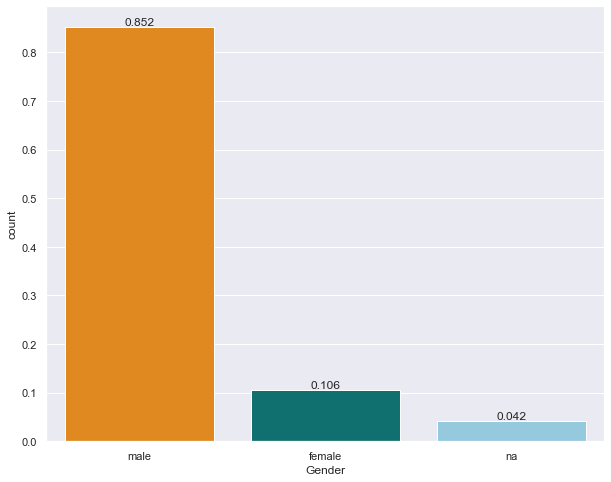

In [92]:
male = len(df[df.Gender =='Male'])/df.shape[0]
female = len(df[df.Gender =='Female'])/df.shape[0]
na = len(df[df.Gender =='na'])/df.shape[0]

d = {'Gender': ['male','female','na'], 'count': [male,female,na]}
dist = pd.DataFrame(data=d)

print("\n"+"Out of " +str(df.shape[0])+ " total transactions, " + str(np.round((male*100),2))+"% are made by male directors, " + str(np.round((female*100),2))+ "% are made by female directors and " + str(np.round((na*100),2))+"% are not identifiable.")

#col=sns.color_palette("pastel")
col=["darkorange","teal","skyblue"]
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(data=dist, x="Gender", y="count",palette=col)

ax.bar_label(ax.containers[0], fmt='%.3f')
plt.savefig(path+"/Vis/"+"bar_dist_gender", dpi=600, bbox_inches='tight')

plt.show()

We will drop all transactions made by a director, that cannot be classified to a gender. This can have different reasons, which will be further explained in the final report. 

In [93]:
print("Number of dropped rows, which cannot be classified to a gender: " + str(len(df[df.Gender =='na'])))
df[df.Gender =='na'].to_excel(path + "NAs.xlsx")
df = df[df["Gender"]!="na"]
print("DF shape after NAs got dropped: " + str(df.shape))

Number of dropped rows, which cannot be classified to a gender: 25368
DF shape after NAs got dropped: (576167, 8)


## Step 3&4: Calculate (Cumulative) Abnormal Returns <a class="anchor" id="step3"></a>


### Import and preprocess daily company and market returns <a class="anchor" id="pp_dr"></a>

In [94]:
if RUN_DAILY_RETURNS == True:
    # first we import the daily returns of the companies
    files = os.listdir(path+"daily/")
    
    daily = pd.DataFrame()
    
    for f in files:
        print(f)
        data = pd.read_excel(path+"daily/"+f,skiprows=5)
        data = data.iloc[1:]
        #transpose isins to row idx
        data = data.transpose()
        #make columns = days 
        data.columns = data.iloc[0]
        data = data.iloc[1:]

        daily = pd.concat([daily,data])
        
    # need to drop this, because company has no daily prices but only value: $$ER: 2381,NO DATA AVAILABLE
    daily = daily.drop('MHY8900D1085')
    daily.to_pickle(path + "daily.pkl")
    DR_companies = daily.pct_change(axis='columns', periods=1)
    DR_companies.replace([np.inf, -np.inf], np.nan, inplace=True)
    DR_companies.to_pickle(path + "DR_companies.pkl")
    
    #Let's also import the daily returns of the market
    daily_market = pd.read_excel(path+"Nasdaq Composite Index (RI (Totlal Return) and PI (Price Index)) 07_1999 - 07_2023.xlsx")
    daily_market.drop([0,1,2,4], inplace=True)
    daily_market = daily_market.transpose()
    daily_market.columns = daily_market.iloc[0]
    daily_market = daily_market.iloc[1:]
    daily_market = daily_market.set_index('Code')

    DR_market = daily_market.pct_change(axis='columns', periods=1)
    DR_market.to_pickle(path + "DR_market.pkl")

else:
    DR_companies = pd.read_pickle(path + "DR_companies.pkl")
    DR_market = pd.read_pickle(path + "DR_market.pkl")

Let's check if all the ISIN Codes are also found in the daily return company list. 
If we have no daily returns for a company, we cannot calculate the AR and therefore drop those rows/transactions.

In [95]:
df_isins = df["ISIN CODE"].tolist()
dr_isins = DR_companies.index.values.tolist()

isin_not_in_dr = set(df_isins)-set(dr_isins)
print(len(isin_not_in_dr))
pd.DataFrame(isin_not_in_dr).to_excel(path+"ISIN_notinDR.xlsx")
df = df[~df['ISIN CODE'].isin(isin_not_in_dr)]
print("DF shape after dropping companies, for which we don't have daily returns: " + str(df.shape))

121
DF shape after dropping companies, for which we don't have daily returns: (571763, 8)


### Calculate Abornal Returns <a class="anchor" id="calcAR"></a>

Some more preprocessing before calculating the individual Abnormal Returns.
For the (C)AR calculations, we need sufficient past daily returns and also a long enough timeframe for the future predictions. 
Thus, we drop all transactions that are too recent (event window too small), as well as all transactions before 01.01.2003. 

In [96]:
print("Number of transactions after June 23 (too recent): " + str(len(df[df['Filing Date'] > "2023-06-01 00:00:00"])))
df[df['Filing Date'] > "2023-06-01 00:00:00"].to_excel(path+"FilingDate_toorecent.xlsx")
df = df.drop(df[df['Filing Date'] > "2023-06-01 00:00:00"].index)

print("\n"+"Number of transactions before 2003 (no market RI data): " + str(len(df[df['Filing Date'] < "2003-01-01 00:00:00"])))
df[df[df['Filing Date'] < "2003-01-01 00:00:00"]].to_excel(path+"FDtooearly_nomarketRI.xlsx")
df = df.drop(df[df['Filing Date'] < "2003-01-01 00:00:00"].index)

#infinite values cannot be processed, we replace them with nan values
DR_companies.replace([np.inf, -np.inf], np.nan, inplace=True)

Number of transactions after June 23 (too recent): 8060

Number of transactions before 2003 (no market RI data): 0


29.06.2023 is missing in the market daily returns

<font color='red'>TODO !!</font>   
DR_market["29.06.2023 00:00:00"] == ? 

In [139]:
if RUN_Calc_AR == True:
    mr = DR_market[:1]
    cols = [str(item)for item in range(-20,21)]
    start_time = time.time()
    epses = []
    empty = pd.DataFrame(np.zeros((1, 41))).astype("float32")
    empty_all = []
    
    for i in range(4):
        scope = np.ceil(df.shape[0]/4).astype("int64")
        print(i)
        start = i*scope
        end = start+scope
        print(start,end)
        
        # cr = company daily return, mr = market daily return
        ARs = pd.DataFrame()
        count = 1
       
        for v in df.values[start:end,:]:

            event_date = v[0]
            isin = v[-1]

            cr = DR_companies.loc[isin]

            abnormal_returns,eps = calculate_AR.run_calculation_AR(event_date,cr,mr)
            
            if abnormal_returns == empty.all():
                empty_all.append(abnormal_returns)
                continue
                
            ARs = pd.concat([ARs,pd.DataFrame(abnormal_returns)])
            epses.append(eps)
            count+=1
        
        ARs.columns = cols
        print(ARs.shape)
        print(df[start:end].shape)
        df_all = pd.concat([df[start:end].reset_index(drop=True), ARs.reset_index(drop=True)], axis=1)
        print(df_all.shape)
        
        # preprocessing: drop all empty rows with no AR
        drop = df_all.iloc[:, 9:51]
        drop['matching'] = drop.eq(drop.iloc[:,0], axis=0).all(1)
        drop_idx = drop[drop["matching"]==True].index.tolist()
        print("Number of empty (only 0s) ARs: " + str(len(drop_idx)))

        ARs =  df_all.drop(df_all.index[d] for d in drop_idx)
        
        print(ARs.shape)
        old_shape =ARs.shape[0]
        #drop empty df
        ARs.dropna(subset="-20",inplace=True)
        ARs.dropna(subset="-1",inplace=True)
        # need to drop SKYX bcs of extreme outliers
        ARs = ARs.drop(ARs[ARs["Ticker"]=="SKYX"].index)
        ARs = ARs.drop(ARs[ARs["Ticker"]=="SKYW"].index)
        print(old_shape-ARs.shape[0])
        
        ARs.to_pickle(path +"/ARs/" +f"ARs_{i}.pkl")
    
        print("--- %s minutes ---" % ((time.time() - start_time)/60))
        break
else:
    ARs = pd.DataFrame()
    for i in range(1):
        part = pd.read_pickle(path+"/ARs/" +f"ARs_{i}.pkl")
        print(part.shape)
        ARs = pd.concat([ARs,part])
    print(ARs.shape)
    ARs = ARs.reset_index(drop=True)

(138277, 50)
(138277, 50)


Visualize Aberage Abnormal Returns

In [156]:
ARs.shape

(138133, 50)

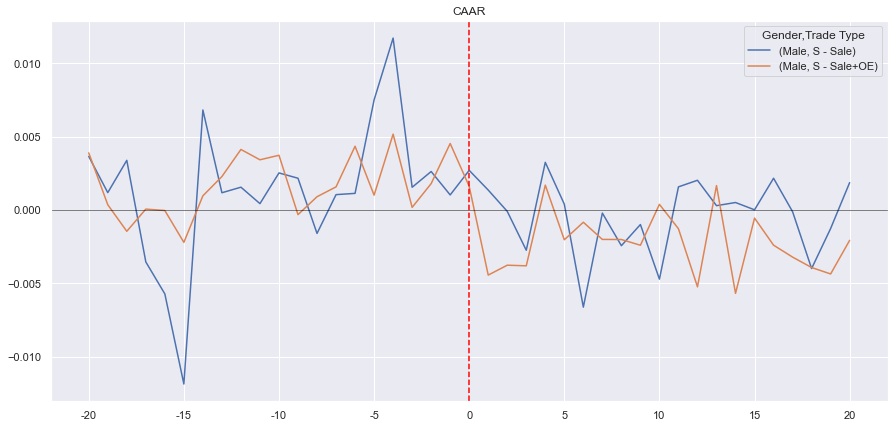

In [163]:
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(15,7)})

fig = ARs.iloc[9:50].groupby(["Gender","Trade Type"]).mean().transpose().plot()
fig.set_title("AAR")
plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")
plt.savefig(path+"/Vis/CAAR", dpi=600, bbox_inches='tight')
plt.show()



### Calculate CAR <a class="anchor" id="calcCAR"></a>

In [140]:
ARs = ARs.drop(ARs[ARs["Ticker"]=="SKYW"].index)

CARs = ARs.iloc[:, 9:51].cumsum(axis=1)
CARs = pd.concat([ARs.iloc[:,1:9],CARs],axis=1)
CARs.to_pickle(path+"CARs.pkl")

## Step 5: Data Analysis // Statistical Testing <a class="anchor" id="step5"></a>

### Cross Sectional Analysis of descriptive statistics  <a class="anchor" id="descr"></a>

In [141]:
groups= ARs.groupby(["Gender","Trade Type"]).size().to_frame(name = 'count').reset_index() 
groups["Share"] = np.round((groups["count"]/ARs.shape[0])*100,2).apply(lambda x: str(x)+"%")
groups

,Gender,Trade Type,count,Share
0,Female,P - Purchase,3225,2.33%
1,Female,S - Sale,5152,3.73%
2,Female,S - Sale+OE,6457,4.67%
3,Male,P - Purchase,34684,25.11%
4,Male,S - Sale,48604,35.19%
5,Male,S - Sale+OE,40009,28.96%


In [142]:
print(groups.to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format))

\begin{tabular}{llrl}
\toprule
Gender &   Trade Type &  count &  Share \\
\midrule
Female & P - Purchase &   3225 &  2.33\% \\
Female &     S - Sale &   5152 &  3.73\% \\
Female &  S - Sale+OE &   6457 &  4.67\% \\
  Male & P - Purchase &  34684 & 25.11\% \\
  Male &     S - Sale &  48604 & 35.19\% \\
  Male &  S - Sale+OE &  40009 & 28.96\% \\
\bottomrule
\end{tabular}



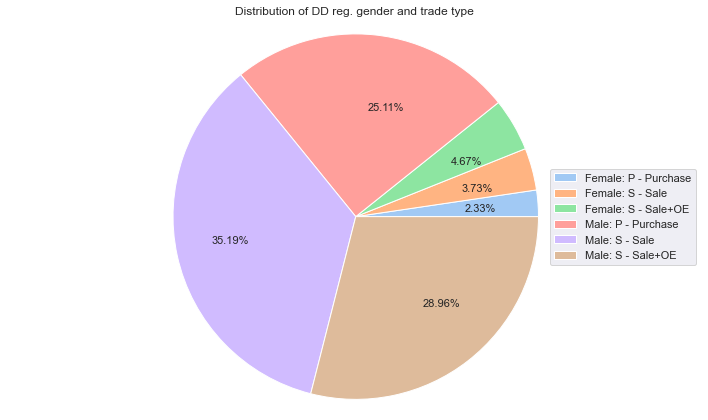

In [153]:
label =groups["Gender"]+": "+groups["Trade Type"]
colors = sns.color_palette('pastel')[0:7]
plt.figure(figsize=(10,6))
#create pie chart
patches, texts =plt.pie(groups["count"],labels=groups["Share"], labeldistance = 0.6,colors = colors)
plt.title("Distribution of DD reg. gender and trade type")
plt.legend(patches, label, loc="right")
plt.savefig(path+"/Vis/Pie_dist_Groups", dpi=600, bbox_inches='tight')

plt.axis('equal')
plt.tight_layout()
plt.show()


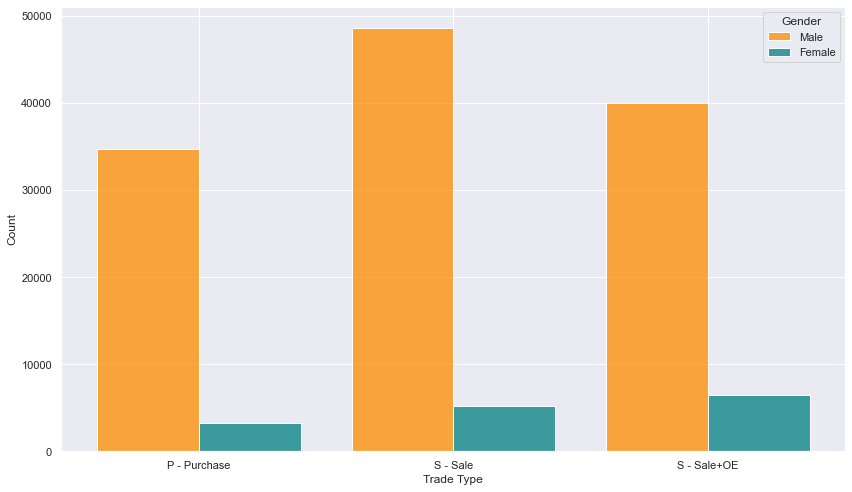

In [144]:
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(12,7)})
col=["darkorange","teal"]
sns.histplot(data = ARs, x="Trade Type", hue="Gender", multiple ="dodge",shrink=.8,palette=col)

plt.savefig(path+"/Vis/bar_Groups", dpi=600, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [145]:
#ARs.groupby(["Gender","Trade Type"]).size().to_frame(name = 'count').reset_index() 

CAAR = CARs.groupby(["Gender","Trade Type"]).mean().transpose()
MCAR = CARs.groupby(["Gender","Trade Type"]).median().transpose()

print(CAAR.describe().to_latex(index=False,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{rrrrrr}
\toprule
      Female & \multicolumn{3}{l}{Male} \\
P - Purchase & S - Sale & S - Sale+OE & P - Purchase & S - Sale & S - Sale+OE \\
\midrule
     41.0000 &  41.0000 &     41.0000 &      41.0000 &  41.0000 &     41.0000 \\
      0.0064 &   0.0330 &      0.0402 &       0.0038 &   0.0548 &      0.0457 \\
      0.0082 &   0.0170 &      0.0221 &       0.0054 &   0.0298 &      0.0251 \\
     -0.0027 &   0.0012 &      0.0013 &      -0.0029 &   0.0025 &      0.0019 \\
     -0.0006 &   0.0188 &      0.0203 &      -0.0007 &   0.0294 &      0.0228 \\
      0.0010 &   0.0399 &      0.0476 &      -0.0004 &   0.0601 &      0.0534 \\
      0.0163 &   0.0478 &      0.0591 &       0.0096 &   0.0799 &      0.0668 \\
      0.0189 &   0.0566 &      0.0691 &       0.0105 &   0.0994 &      0.0802 \\
\bottomrule
\end{tabular}



Visualize descriptive stats

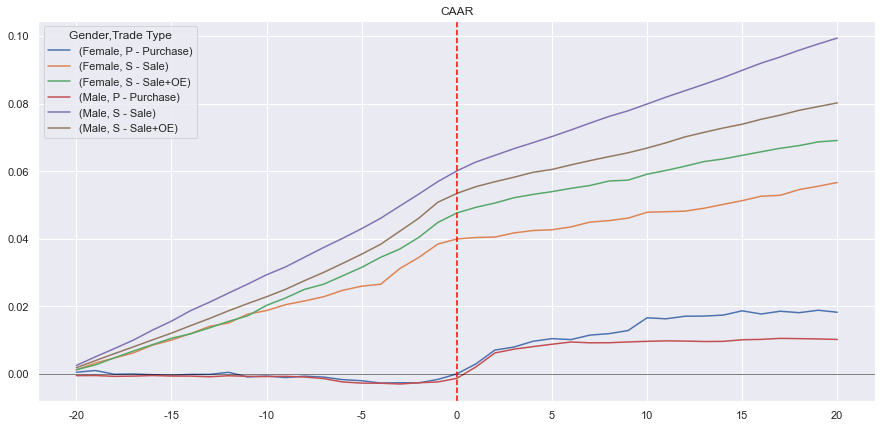

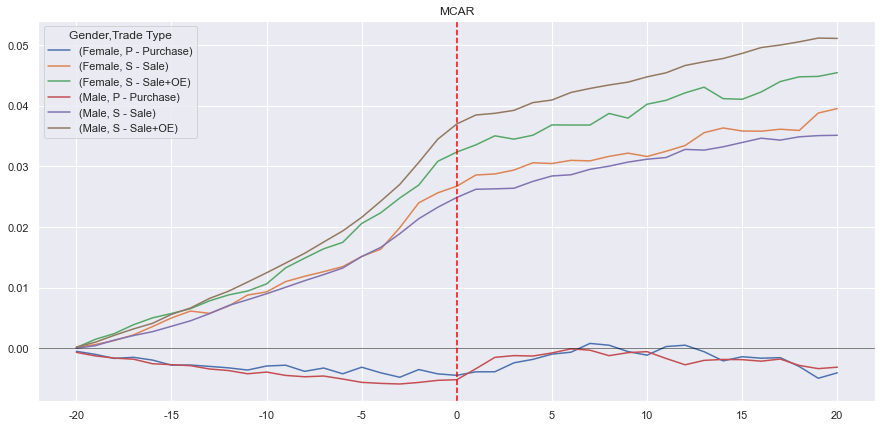

In [146]:
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(15,7)})

CAAR['Day'] = CAAR.index
fig = CAAR.plot().set_title("CAAR")
plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")
plt.savefig(path+"/Vis/CAAR", dpi=600, bbox_inches='tight')
plt.show()

MCAR['Day'] = MCAR.index
fig = MCAR.plot().set_title("MCAR")
plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")
plt.savefig(path+"/Vis/MCAR", dpi=600, bbox_inches='tight')
plt.show()

26.0
27.804549114331724


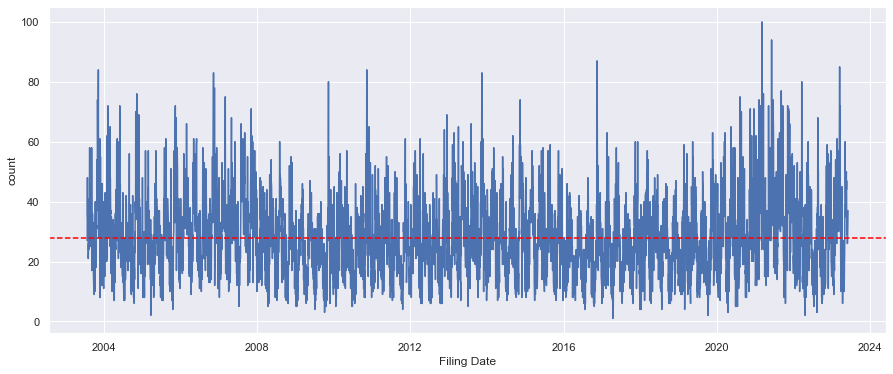

In [147]:
dates_cluster = ARs.groupby(["Filing Date"]).size().to_frame(name = 'count').reset_index() 
print(dates_cluster["count"].median())
print(dates_cluster["count"].mean())

plt.figure(figsize=(15,6))
sns.lineplot(data=dates_cluster, x="Filing Date", y="count")
plt.axhline(y=dates_cluster["count"].mean(),color="red",ls="--")

plt.savefig(path+"/Vis/dates_cluster", dpi=600, bbox_inches='tight')

In [148]:
top10_dates = dates_cluster.sort_values(by="count", ascending=False)[:10]
print(top10_dates.to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format))

\begin{tabular}{lr}
\toprule
Filing Date &  count \\
\midrule
 2021-03-03 &    100 \\
 2021-06-03 &     94 \\
 2016-11-14 &     87 \\
 2023-03-13 &     85 \\
 2003-11-12 &     84 \\
 2010-11-12 &     84 \\
 2013-11-12 &     83 \\
 2006-11-13 &     83 \\
 2022-03-17 &     80 \\
 2009-11-12 &     80 \\
\bottomrule
\end{tabular}



### Let's analyze the different time frames

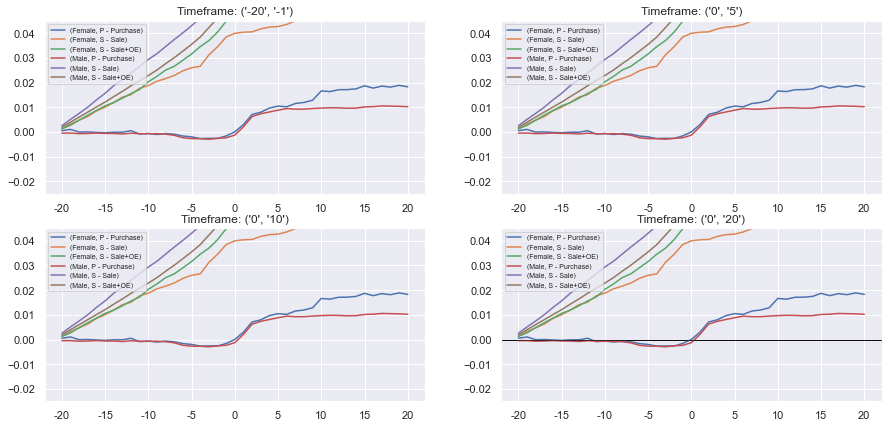

In [149]:
stats = pd.DataFrame()
timeframes = [("-20","-1"),("0","5"),("0","10"),("0","20")]
row,col = 0,0

fig, axs = plt.subplots(ncols=2,nrows=2)
plt.figsize=(10,10)
for tf in timeframes:
    CAR = CARs.loc[:,tf[0]:tf[1]]
    
    CAAR = CARs.groupby(["Gender","Trade Type"]).mean().transpose()
   
    
    fig = CAAR.plot(ax=axs[col][row])
    fig.set_title("Timeframe: "+str(tf))
    fig.legend(fontsize="7" ,loc="upper left")
    fig.set(ylim=(-0.025,0.045))
    if (row == 0) & (col==0):
        row=1
        
    elif (row == 0) & (col==1):
        row=1
        col=1
    elif (row == 1) & (col==0):
        row=0
        col=1
   
    plt.axhline(0,color="black",linewidth=0.5)    
    
    descr_stats =CAAR.describe().transpose()
    descr_stats["timeframe"]=str(tf)
    stats = pd.concat([stats,descr_stats])
    
plt.savefig(path+"/Vis/tfs", dpi=600, bbox_inches='tight')
plt.show()    

## Statistical Hypothesis Testing  <a class="anchor" id="ttest"></a>

### Adjusted Standardized Cross-Sectional test based on Kolari and Pynnönen (2010), parametric test  <a class="anchor" id="t1"></a>

In [ ]:
if RUN_TTESTS: 
    %run ttest.py
else: 
    ttest_params = pd.read_pickle(path+"ttest_params.pkl")
    ttest_results = pd.read_pickle(path+"ttest_results.pkl")

In [ ]:
ttest_df = pd.DataFrame(ttest_results, index=pd.MultiIndex.from_tuples(ttest_params, names=["Trade Type", "CAR timeframe"]))
ttest_df.columns = ["Δ CAAR", "p-value"]
print(ttest_df.to_latex(formatters={"name": str.upper},float_format="{:.5f}".format))

### Generalized Rank Test based on Kolari and Pynnönen (2011), non-parametric test <a class="anchor" id="t2"></a>

In [ ]:
if RUN_TTESTS: 
    %run rtest.py
else: 
    rtest_params = pd.read_pickle(path+"rtest_params.pkl")
    rtest_results = pd.read_pickle(path+"rtest_results.pkl")